## Image Classification using Pretrained Network

### VGGNet trained on the ImageNet dataset as a feature extractor

#### By Prof. Chitra Desai

#### Data Set
- Flower data set is used which consist of two types of flower Daisy and Dandelion.
- Training set with 200 samples of each class.
- Test set with 100 samples of each class.

In [186]:
import keras,os
from keras.models import Sequential # Gets our neural network as sequential network
from keras.layers import Conv2D # Images are basically 2D
from keras.layers import MaxPool2D # Average Pooling, Sum Pooling and Max Pooling is there. we use Max pooling
from keras.layers import Flatten # It is process of converting all 2D array to continious linear vector
from keras.layers import Dense # Full connection of this neural network is performed using dense
from keras.preprocessing.image import ImageDataGenerator # It helps rescale, flip, rotate etc
import numpy as np


#### 1: Opening and Creating file path

In [187]:
import os,random
base_dir = r'C:\Users\ChitraDesai\Assignment\Flower detection_Assignment\data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_daisy_dir = os.path.join(train_dir, 'daisy')

train_dandelion_dir = os.path.join(train_dir, 'dandelion')

test_daisy_dir = os.path.join(test_dir, 'daisy')
test_dandelion_dir = os.path.join(test_dir, 'dandelion')



#### 2: Opening and Writing to Image Files

In [188]:
train_size, test_size = 200, 100
img_width, img_height=224,224

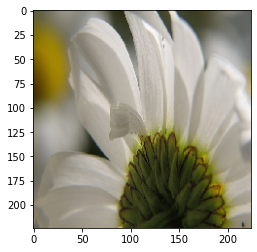

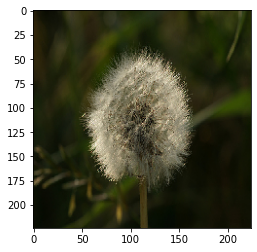

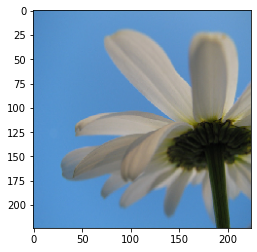

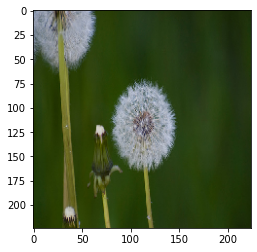

In [189]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_daisy_dir)
    show_pictures(train_dandelion_dir)

#### Extract Features
In this example, we want to use a solution based on pre-trained models. We will use models that are composed of two parts:
* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as daisy or dandelion.

#### 3: Import the VGG16 pretrained model

In [190]:
# Import VGG16 Pretrained model
# Instantiate convolutional base
from keras.applications import VGG16
from keras import layers
from keras import optimizers

In [191]:
vgg16covbase= VGG16(weights='imagenet', # pretraining on imagenet
                  include_top=False, # whether to include the 3 fully-connected layers at the top of the network.
                  input_shape=(224, 224, 3))  # 3 = number of channels in RGB pictures
# The entire layers are present inside this.The feature extractor is inbuilt

#### 4: Model summary of the pre-trained model.

In [192]:
vgg16covbase.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### 5 : Create feature extractor for train and test

In [193]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(224,224),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16covbase.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size

test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [194]:
#for layer in vgg16covbase.layers:
    #layer.trainable = False

In [195]:
# Make sure you have frozen the correct layers
#for i, layer in enumerate(vgg16covbase.layers):
    #print(i, layer.name, layer.trainable)

#### 6: Build a fully-connected layer model with activation function "Relu" and Number of training epochs 100.

In [196]:
from keras import models

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [197]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

#### 7: Train the model with train_feature and train_labels.

In [198]:
history = model.fit(train_features, labels,
                    epochs=100,
                    batch_size=batch_size, 
                    validation_data=(test_features, test_labels))

Epoch 1/100
7/7 [==============================] - 0s 63ms/step - loss: 3.2243 - acc: 0.4950 - val_loss: 1.2262 - val_acc: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 47ms/step - loss: 1.5366 - acc: 0.5200 - val_loss: 1.5245 - val_acc: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 45ms/step - loss: 1.3025 - acc: 0.5800 - val_loss: 1.1393 - val_acc: 0.3800
Epoch 4/100
7/7 [==============================] - 0s 43ms/step - loss: 0.7035 - acc: 0.6400 - val_loss: 0.9567 - val_acc: 0.4700
Epoch 5/100
7/7 [==============================] - 0s 46ms/step - loss: 0.5329 - acc: 0.6850 - val_loss: 0.9523 - val_acc: 0.3800
Epoch 6/100
7/7 [==============================] - 0s 44ms/step - loss: 0.4270 - acc: 0.7950 - val_loss: 0.9702 - val_acc: 0.3800
Epoch 7/100
7/7 [==============================] - 0s 46ms/step - loss: 0.4596 - acc: 0.7950 - val_loss: 0.8986 - val_acc: 0.4200
Epoch 8/100
7/7 [==============================] - 0s 44ms/step - loss: 0.3264 - acc: 0.88

7/7 [==============================] - 0s 41ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 2.1084 - val_acc: 0.4500
Epoch 64/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0161 - acc: 0.9950 - val_loss: 2.0977 - val_acc: 0.4600
Epoch 65/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 1.0000 - val_loss: 2.1407 - val_acc: 0.4700
Epoch 66/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0150 - acc: 0.9950 - val_loss: 2.0962 - val_acc: 0.4600
Epoch 67/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 2.0924 - val_acc: 0.4600
Epoch 68/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0149 - acc: 1.0000 - val_loss: 2.0973 - val_acc: 0.4600
Epoch 69/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 2.1485 - val_acc: 0.3900
Epoch 70/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0152 - acc: 1.0000 - 

In [199]:
# Save model
model.save('vgg16_2.h5')

#### 8. Model Evaluation and Learning Curve

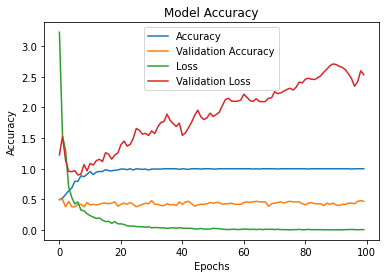

In [200]:
# Plot results
import matplotlib.pyplot as plt

plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epochs')
plt.legend(['Accuracy','Validation Accuracy','Loss', 'Validation Loss'])

#### 9. Model Prediction

In [201]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_daisy_dir, test_dandelion_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = vgg16covbase.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('daisy')
        else:
            print('dandelion')

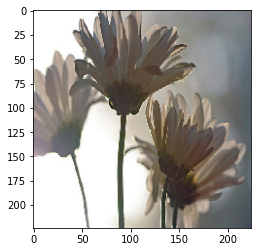

dandelion


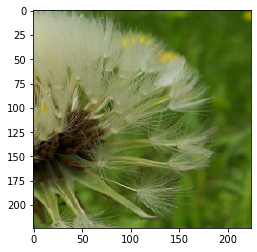

daisy


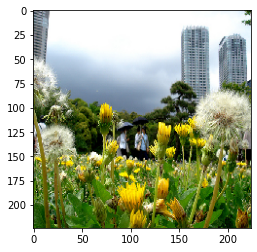

daisy


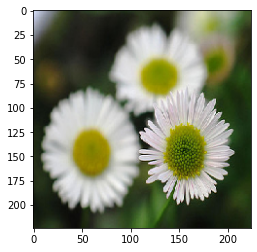

dandelion


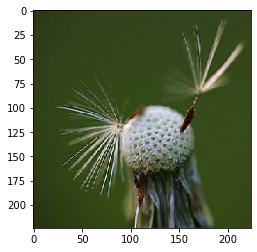

daisy


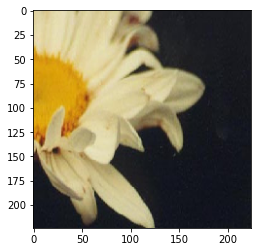

daisy


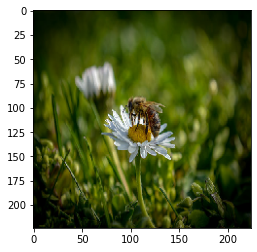

daisy


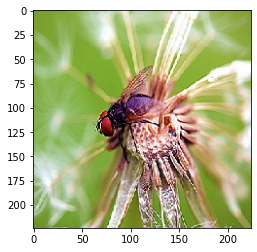

daisy


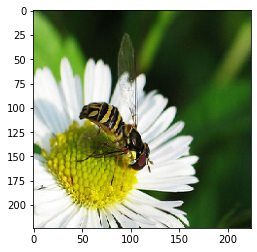

daisy


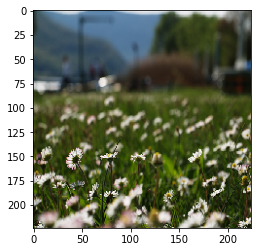

daisy


In [209]:
# Visualize predictions
visualize_predictions(model, 10)